In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit.library import QAOAAnsatz
import time
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

In [18]:
QiskitRuntimeService.delete_account()
#
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='f812b20b65e661d9f78d44e11b1078feb0efc222ab12cdf8d1aea3e2f0f8afb6410cc670110338907c2e71685445319d89cd5258adc567a1e439be10a05eb460', overwrite=True)

# QiskitRuntimeService.save_account(token="0aDpWunMlDZRivTJVWW3KpsXTdgqE1vzfPB8_ODD4Phx", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/0d5f2945f5c44fd6a69d8a9dd034808c:2e832f3b-b7a7-466c-b735-53a9ed77d94b::", overwrite=True)

In [19]:
service = QiskitRuntimeService()

for backend in service.backends(simulator=False, operational=True):
    print(f"{backend.name} – {backend.configuration().num_qubits} qubits")

/var/folders/j_/6x8b_dk9253_tf1dd1vvw84r0000gn/T/ipykernel_18741/1411517592.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


ibm_brisbane – 127 qubits
ibm_sherbrooke – 127 qubits


In [20]:
def generate_graph(num_nodes, edge_prob=0.5):
    return nx.erdos_renyi_graph(num_nodes, edge_prob)

In [21]:
import numpy as np

# QUBO conversion and Hamiltonian construction
def create_qubo_hamiltonian(graph, num_colors=3):
    num_nodes = graph.number_of_nodes()
    Q = np.zeros((num_nodes * num_colors, num_nodes * num_colors))
    for i in range(num_nodes):
        for c in range(num_colors):
            Q[i * num_colors + c, i * num_colors + c] -= 1
            for cp in range(c + 1, num_colors):
                Q[i * num_colors + c, i * num_colors + cp] += 2
    for i, j in graph.edges():
        for c in range(num_colors):
            Q[i * num_colors + c, j * num_colors + c] += 1
    Q = 0.5 * (Q + Q.T)
    linear = np.diag(Q)
    quadratic = Q - np.diag(linear)
    h = {i: linear[i] for i in range(len(linear))}
    J = {(i, j): quadratic[i, j] for i in range(len(linear)) for j in range(i + 1, len(linear)) if quadratic[i, j] != 0}

    pauli_list = []
    for (i, j), weight in J.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        z_p[j] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    for i, weight in h.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    hamiltonian = sum([SparsePauliOp.from_list([(pauli.to_label(), weight)]) for pauli, weight in pauli_list])

    return hamiltonian

In [22]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [23]:
# import numpy as np
# from qiskit.transpiler import generate_preset_pass_manager
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
#
# def run_qaoa(graph, p=3, max_iter=500, shots=1024):
#
#     global evaluation_count, iteration_count,qaoa_exec_time,simulation_time
#     evaluation_count = 0
#     iteration_count = 0
#     qaoa_exec_time = 0
#     simulation_time = 0
#
#     cost_hamiltonian = create_qubo_hamiltonian(graph)
#
#     quantum_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
#     quantum_circuit.measure_all()
#
#     service_refresh = QiskitRuntimeService()
#     backend_refresh = service_refresh.backend("ibm_sherbrooke")
#
#     # n_qubits = graph.number_of_nodes()
#     # backend = service.least_busy(
#     #     operational=True, simulator=False, min_num_qubits=n_qubits
#     # )
#
#     pm = generate_preset_pass_manager(backend=backend_refresh, optimization_level=1)
#     isa_circuit = pm.run(quantum_circuit)
#
#     sampler = Sampler(backend_refresh)
#     job = sampler.run([(isa_circuit, init_params)])
#     job_result = job.result()
#     estimated_time = job.usage_estimation
#     real_execution_time_in_sec = job_result.metadata['execution']['execution_spans'].duration # duration in sec
#     # pub_result = job_result[0]
#     # print(f" > First ten results: {pub_result.data.meas.get_bitstrings()[:10]}")
#
#     return real_execution_time_in_sec, estimated_time


In [24]:
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.quantum_info import Pauli, SparsePauliOp
import time

def run_qaoa(graph, p=1, max_iter=30, shots=512, num_colors=3):

    global evaluation_count, iteration_count, qaoa_exec_time, simulation_time
    evaluation_count = 0
    iteration_count = 0
    qaoa_exec_time = 0
    simulation_time = 0

    start_time = time.time()

    # Create cost Hamiltonian for graph coloring
    cost_hamiltonian = create_qubo_hamiltonian(graph, num_colors)

    # Create QAOA ansatz
    quantum_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
    _backend = service.least_busy(
        operational=True, simulator=False, min_num_qubits=graph.number_of_nodes(),
    )
    print(_backend)

    # Transpile circuit and get the mapping
    pm = generate_preset_pass_manager(backend=_backend, optimization_level=3, seed_transpiler=42)
    isa_circuit = pm.run(quantum_circuit)

    # Initialize estimator
    estimator = Estimator(_backend)
    estimator.options.resilience_level = 0
    estimator.options.default_shots = 250

    objective_func_vals = [] # Global variable
    def cost_func_estimator(params, ansatz, hamiltonian, estimator):
        isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

        pub = (ansatz, isa_hamiltonian, params)
        job = estimator.run([pub])

        results = job.result()[0]
        cost = results.data.evs
        objective_func_vals.append(cost)
        return cost

    # Initialize parameters randomly
    num_params = quantum_circuit.num_parameters
    initial_params = np.random.uniform(-np.pi/6, np.pi/6, num_params)

    # Efficient optimization with strict limits
    optimization_options = {
        'maxiter': max_iter,
        'catol': 1e-2,          # Relaxed convergence
        'disp': False           # Reduce output
    }
    # Run classical optimization
    result = minimize(
        cost_func_estimator,
        initial_params,
        args=(isa_circuit, cost_hamiltonian, estimator),
        method='COBYLA',
        options=optimization_options
    )

    # For final measurement, use Sampler
    sampler = Sampler(_backend)
    optimal_circuit = isa_circuit.assign_parameters(result.x)
    optimal_circuit.measure_all()

    final_job = sampler.run([(optimal_circuit, None)])
    final_result = final_job.result()

    # Extract execution time from the final job
    real_execution_time = final_result.metadata['execution']['execution_spans'].duration
    # Get the best coloring from final measurements
    # final_counts = final_result[0].data.meas.get_counts()
    # best_bitstring = max(final_counts, key=final_counts.get)

    return real_execution_time

In [25]:
def dsatur_coloring(graph):
    coloring = {}
    saturation_degrees = {node: 0 for node in graph.nodes()}
    available_colors = [True] * len(graph.nodes())
    iterations = 0
    while len(coloring) < len(graph.nodes()):
        iterations += 1
        uncolored_nodes = [node for node in graph.nodes() if node not in coloring]
        max_saturation = -1
        selected_node = None
        for node in uncolored_nodes:
            if saturation_degrees[node] > max_saturation:
                max_saturation = saturation_degrees[node]
                selected_node = node
            elif saturation_degrees[node] == max_saturation:
                if selected_node is None or graph.degree[node] > graph.degree[selected_node]:
                    selected_node = node
        neighbor_colors = {coloring[neighbor] for neighbor in graph.neighbors(selected_node) if neighbor in coloring}
        for color in range(len(available_colors)):
            if color not in neighbor_colors:
                coloring[selected_node] = color
                break
        for neighbor in graph.neighbors(selected_node):
            if neighbor not in coloring:
                saturation_degrees[neighbor] += 1
    return coloring, iterations

In [26]:
def run_dsatur(graph):
    start_time = time.time()
    _, classical_iter = dsatur_coloring(graph)
    classical_time = time.time() - start_time
    return classical_time, classical_iter

In [27]:
# Initialize lists to store the results
real_quantum_times = []
num_nodes_list = []

In [ ]:
import logging

# Configure logging
logging.basicConfig(filename='graph_coloring_results.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s', filemode='w')  # 'w' to overwrite each time

for num_nodes in range(7, 11):
    G = generate_graph(num_nodes)
    real_execution_time_in_sec = run_qaoa(G)

    # Collect results
    num_nodes_list.append(num_nodes)
    real_quantum_times.append(real_execution_time_in_sec)


<IBMBackend('ibm_brisbane')>


base_primitive._run:INFO:2025-06-20 10:08:25,143: Submitting job using options {'options': {'default_shots': 250}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}
base_primitive._run:INFO:2025-06-20 10:12:02,400: Submitting job using options {'options': {'default_shots': 250}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}
base_primitive._run:INFO:2025-06-20 10:14:13,453: Submitting job using options {'options': {'default_shots': 250}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}
base_primitive._run:INFO:2025-06-20 10:15:03,625: Submitting job using options {'options': {'default_shots': 250}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}


In [13]:
# import logging
# import threading
# from concurrent.futures import ThreadPoolExecutor, as_completed
#
# # Configure logging
# logging.basicConfig(filename='graph_coloring_results.log', level=logging.INFO,
#                     format='%(asctime)s - %(message)s', filemode='w')  # 'w' to overwrite each time
#
# # Thread-safe result collection
# results_lock = threading.Lock()
#
# def run_qaoa_for_node(num_nodes):
#     """Run QAOA for a single node count"""
#     try:
#         print(f"Starting QAOA for {num_nodes} nodes...")
#         logging.info(f"Starting QAOA for {num_nodes} nodes")
#
#         G = generate_graph(num_nodes)
#         print(f"Generated graph for {num_nodes} nodes")
#
#         real_execution_time_in_sec, estimated_time = run_qaoa(G)
#         print(f"QAOA completed for {num_nodes} nodes: {estimated_time:.2f}s")
#
#         # Thread-safe result collection
#         with results_lock:
#             num_nodes_list.append(num_nodes)
#             real_quantum_times.append(real_execution_time_in_sec)
#             estimated_quantum_times.append(estimated_time)
#
#         logging.info(f"Completed {num_nodes} nodes: {estimated_time:.2f}s")
#         return True
#
#     except Exception as e:
#         error_msg = f"Failed {num_nodes} nodes: {type(e).__name__}: {str(e)}"
#         print(error_msg)
#         logging.error(error_msg)
#         import traceback
#         traceback.print_exc()  # Print full stack trace
#         logging.error(f"Full traceback for {num_nodes} nodes: {traceback.format_exc()}")
#         return False
#
# # Parallel execution with minimal changes
# node_range = range(3, 5)  # Update range as needed
# max_workers = 1  # Adjust based on your account limits
#
# print(f"Starting parallel QAOA for nodes: {list(node_range)}")
# print(f"Using {max_workers} parallel workers")
#
# with ThreadPoolExecutor(max_workers=max_workers) as executor:
#     # Submit all tasks
#     futures = {executor.submit(run_qaoa_for_node, num_nodes): num_nodes for num_nodes in node_range}
#
#     # Wait for completion and log progress
#     for future in as_completed(futures):
#         num_nodes = futures[future]
#         try:
#             success = future.result()
#             if success:
#                 print(f"✓ Node {num_nodes} completed successfully")
#             else:
#                 print(f"✗ Node {num_nodes} failed (check logs for details)")
#         except Exception as e:
#             error_msg = f"✗ Node {num_nodes} exception: {type(e).__name__}: {str(e)}"
#             print(error_msg)
#             logging.error(error_msg)
#
# print(f"Parallel execution complete. Results collected: {len(num_nodes_list)} out of {len(node_range)}")

In [14]:
import json

experiment_data = {"experiment_data": {}}

for i in range(len(num_nodes_list)):
    num_nodes = str(num_nodes_list[i])

    if num_nodes not in experiment_data["experiment_data"]:
        experiment_data["experiment_data"][num_nodes] = {}

    if num_nodes in experiment_data["experiment_data"]:
        experiment_data["experiment_data"][num_nodes]["real_quantum_times"]=real_quantum_times[i]

# Save to JSON file
with open('experiment_data.json', 'w') as f:
    json.dump(experiment_data, f, indent=2)

print("Data organized and saved to experiment_data.json")

Data organized and saved to experiment_data.json


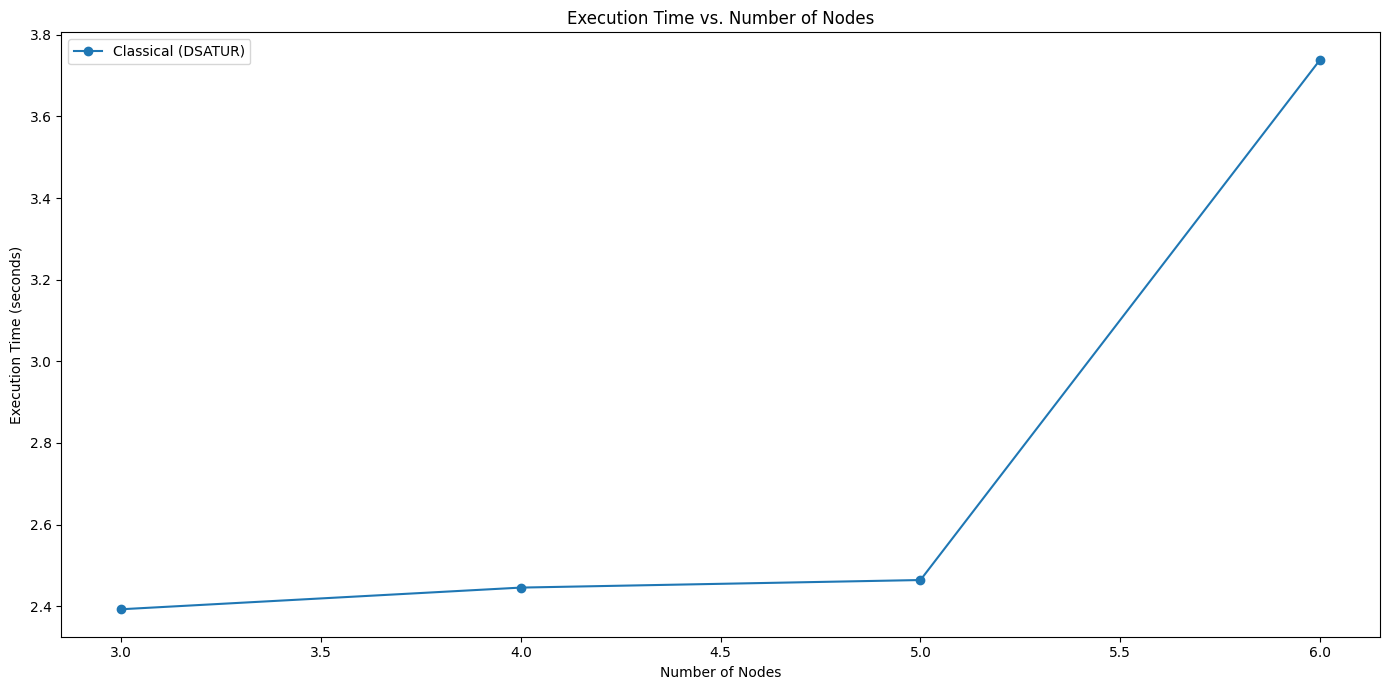

In [16]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot execution times
plt.subplot(1, 1, 1)
# plt.plot(num_nodes_list, estimated_quantum_times, label='Quantum (QAOA)', marker='o')
plt.plot(num_nodes_list, real_quantum_times, label='Classical (DSATUR)', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs. Number of Nodes')
plt.legend()

plt.tight_layout()
plt.show()